In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cloudvolume
import caveclient
import pcg_skel

client = caveclient.CAVEclient('minnie65_public')
cv_minnie = cloudvolume.CloudVolume(client.info.segmentation_source(), use_https=True)

## Initialize local cloudvolume to dump precomputed

In [4]:
local_path = 'file://C:/Users/bethanny.danskin/jupyter_files/cloudvolume_local/precomputed_skeletons'
cv_local = cloudvolume.CloudVolume(local_path, compress=False)
sk_info = cv_local.skeleton.meta.info
sk_info

{'@type': 'neuroglancer_skeletons',
 'transform': [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
 'vertex_attributes': [{'id': 'radius',
   'data_type': 'float32',
   'num_components': 1},
  {'id': 'vertex_types', 'data_type': 'float32', 'num_components': 1},
  {'id': 'presyn_counts', 'data_type': 'uint8', 'num_components': 1},
  {'id': 'postsyn_counts', 'data_type': 'uint8', 'num_components': 1}],
 'spatial_index': None}

### update the skeleton properties type if necessary

In [5]:
# change cloudvolume properties 
sk_info = cv_local.skeleton.meta.default_info()
sk_info
sk_info['transform'] = [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]
sk_info['vertex_attributes'] = [
    { 'id': 'radius',
        'data_type': 'float32',
        'num_components': 1
    },
    {
        'id': 'vertex_types',
        'data_type': 'float32',
        'num_components': 1
    },
    {
        'id': 'presyn_counts',
        'data_type': 'float32',
        'num_components': 1
    },
    {
        'id': 'postsyn_counts',
        'data_type': 'float32',
        'num_components': 1
    }
]
cv_local.skeleton.meta.info = sk_info
cv_local.skeleton.meta.commit_info()
cv_local.skeleton.meta.info

{'@type': 'neuroglancer_skeletons',
 'transform': [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
 'vertex_attributes': [{'id': 'radius',
   'data_type': 'float32',
   'num_components': 1},
  {'id': 'vertex_types', 'data_type': 'float32', 'num_components': 1},
  {'id': 'presyn_counts', 'data_type': 'float32', 'num_components': 1},
  {'id': 'postsyn_counts', 'data_type': 'float32', 'num_components': 1}],
 'sharding': None,
 'spatial_index': None}

## Load .swc and format as precomputed
Uses skeleton_plot skel_io https://github.com/AllenInstitute/skeleton_plot/blob/main/skeleton_plot/skel_io.py

In [6]:
import skeleton_plot as skelplot
import skeleton_plot.skel_io as skel_io

.swc are saved and browseable in the following google bucket [v661 raw](https://console.cloud.google.com/storage/browser/allen-minnie-phase3/minniephase3-emily-pcg-skeletons/minnie_all/v661/skeletons) 

In [7]:
# raw skeleton files
skel_path = "https://storage.googleapis.com/allen-minnie-phase3/minniephase3-emily-pcg-skeletons/minnie_all/v661/skeletons/"

### select example cell

In [8]:
# Example skeleton
nucleus_id = 292685
segment_id = 864691135122603047
skel_filename = f"{segment_id}_{nucleus_id}.swc"
sk = skel_io.read_skeleton(skel_path, skel_filename)

### extract the features for precomputed

In [9]:
# extract vertices, edges, radius, compartment labels
vertices = sk.vertices
edges = sk.edges
radius = sk.vertex_properties['radius'].values
compartment = sk.vertex_properties['compartment'].values

In [10]:
# write precomputed skeleton to disk
sk_cv = cloudvolume.Skeleton(vertices, 
                             edges, 
                             radius,
                             None, 
                             segid=1, # segment_id
                             extra_attributes = sk_info['vertex_attributes'])
sk_cv.vertex_types = compartment.astype(np.float32)
sk_cv.presyn_counts = np.zeros(len(compartment)).astype(int)
sk_cv.postsyn_counts = np.zeros(len(compartment)).astype(int)

# meta information to add: nucleus id; cell type classification; brain visual area

cv_local.skeleton.upload(sk_cv)

## Load .h5 meshwork and format as precomputed

In [11]:
# path to the skeleton and meshwork .h5 files
mesh_path = "https://storage.googleapis.com/allen-minnie-phase3/minniephase3-emily-pcg-skeletons/minnie_all/v661/meshworks/"

### select example cell

In [12]:
# Example meshwork
nucleus_id = 292685
segment_id = 864691135122603047
mw = skel_io.load_mw(mesh_path, f"{segment_id}_{nucleus_id}.h5")

### extract the features for precomputed

Reference: https://github.com/AllenInstitute/skeleton_plot/blob/main/skeleton_plot/utils.py

In [13]:
def pull_mw_skel_colors(mw, basal_table, axon_table, apical_table):
    ''' pulls the segment properties from meshwork anno and translates into skel index
    basal node table used for general dendrite labels if no apical/basal differentiation
    apical_table is optional 
    '''
    node_labels = np.full(len(mw.skeleton.vertices), 0)
    soma_node = mw.skeleton.root
    
    basal_nodes = mw.anno[basal_table].skel_index
    node_labels[basal_nodes] = 3

    node_labels[soma_node] = 1

    axon_nodes = mw.anno[axon_table].skel_index

    if apical_table is not None:
        apical_nodes = mw.anno[apical_table].skel_index
        node_labels[apical_nodes] = 4            
    
    node_labels[axon_nodes] = 2

    if 0 in node_labels:
        print("Warning: label annotations passed give labels that are shorter than total length of skeleton nodes to label. Unassigned nodes have been labeled 0. if using pull_compartment_colors, add an option for 0 in inskel_color_map such as skel_color_map={3: 'firebrick', 4: 'salmon', 2: 'steelblue', 1: 'olive', 0:'gray'}.")

    return node_labels

In [14]:
# extract vertices, edges, radius, compartment labels
vertices = mw.skeleton.vertices
edges = mw.skeleton.edges

# pulls the segment properties from meshwork anno and translates into skel index
r_df = mw.anno.segment_properties.df[['r_eff', 'mesh_ind_filt']].set_index('mesh_ind_filt')
radius = r_df.loc[mw.skeleton_indices.to_mesh_region_point].r_eff.values/1000

# get compartment labels
compartment = pull_mw_skel_colors(mw, 'basal_mesh_labels', 'is_axon', 'apical_mesh_labels')

In [15]:
# Quantify synapses by node
postsyn_counts_df = pd.DataFrame(mw.anno.post_syn.df['post_pt_mesh_ind_filt'].value_counts())
postsyn_counts_df.index.names = ['mesh']

postsyn_mesh = pd.DataFrame(mw.mesh_indices.to_skel_index_padded, columns=['skel'])
postsyn_mesh.index.names=['mesh']
postsyn_mesh['counts'] = 0
postsyn_mesh.loc[postsyn_counts_df.index, 'counts'] = postsyn_counts_df['count']

presyn_counts_df = pd.DataFrame(mw.anno.pre_syn.df['pre_pt_mesh_ind_filt'].value_counts())
presyn_counts_df.index.names = ['mesh']

presyn_mesh = pd.DataFrame(mw.mesh_indices.to_skel_index_padded, columns=['skel'])
presyn_mesh.index.names=['mesh']
presyn_mesh['counts'] = 0
presyn_mesh.loc[presyn_counts_df.index, 'counts'] = presyn_counts_df['count']

postsyn_skel_counts = postsyn_mesh.groupby('skel').sum()
presyn_skel_counts = presyn_mesh.groupby('skel').sum()

In [16]:
postsyn_counts_df

,count
mesh,
8007,16
8747,7
13666,7
15560,7
11071,7
...,...
4215,1
6308,1
6997,1


In [19]:
# write precomputed skeleton to disk
sk_cv = cloudvolume.Skeleton(vertices, 
                             edges, 
                             radius,
                             None, 
                             segid=2, # segment_id
                             extra_attributes = sk_info['vertex_attributes'])
sk_cv.vertex_types = compartment.astype(np.float32)
sk_cv.presyn_counts = presyn_skel_counts.values
sk_cv.postsyn_counts = postsyn_skel_counts.values

# meta information to add: nucleus id; cell type classification; brain visual area

cv_local.skeleton.upload(sk_cv)

## Generate skeleton with pcg-skel, save precomputed

This require CAVEclient and the associated OAuth login, even for public. For setting up a CAVE token, see: https://alleninstitute.github.io/microns_tutorial/programmatic_access/em_py_01_caveclient_setup.html

A skeleton generated from pcg-skel will not have compartment labels, unless run through the apical- and axon-classifiers. This is not trivial, and probably beyond the scope of the SWDB course

### select example cell

In [20]:
input_id = 864691135118968029
id_is_nuc = False

# Cell identification meta info
synapse_table = client.info.get_datastack_info()['synapse_table']
if id_is_nuc:
    id_col = 'id'
else:
    id_col = 'pt_root_id'
use_view = True
if use_view:
    row = client.materialize.query_view('nucleus_detection_lookup_v1', 
                filter_equal_dict = {id_col: input_id})
else:
    row = client.materialize.query_table('nucleus_detection_v0', 
                filter_equal_dict = {id_col: input_id})
    
    row = row.drop('created', axis = 1)

nuc_id = int(row['id']) 
root_id = int(row['pt_root_id'])
root_point = row['pt_position'].values[0]

## Can also lookup information about the cell type and brain area here

print(f'starting on body {nuc_id}, {root_id}')

starting on body 394398, 864691135118968029


### generate a meshwork with pcg-skel

In [21]:
# create whole neuron with radius info
resample_spacing = 1510
collapse_soma = True
collapse_radius = 10_000
res = [4, 4, 40]
mw =  pcg_skel.coord_space_meshwork(root_id,
                                     client=client,
                                     root_point=root_point,
                                     root_point_resolution=res,
                                     collapse_soma=collapse_soma,
                                     collapse_radius=collapse_radius,
                                     synapses='all',
                                     synapse_table=synapse_table,
                                     cv = cv_minnie)
# add radius properties df to annotations 
pcg_skel.features.add_volumetric_properties(mw, client)
print('adding segment properties')
pcg_skel.features.add_segment_properties(mw)
print('segment properties added')

adding segment properties
segment properties added


### extract the features for precomputed

In [22]:
# extract vertices, edges, radius, compartment labels
vertices = mw.skeleton.vertices
edges = mw.skeleton.edges

# pulls the segment properties from meshwork anno and translates into skel index
r_df = mw.anno.segment_properties.df[['r_eff', 'mesh_ind_filt']].set_index('mesh_ind_filt')
radius = r_df.loc[mw.skeleton_indices.to_mesh_region_point].r_eff.values/1000

# empty compartment labels
compartment = np.zeros(len(radius))

In [23]:
# Quantify synapses by node
postsyn_counts_df = pd.DataFrame(mw.anno.post_syn.df['post_pt_mesh_ind_filt'].value_counts())
postsyn_counts_df.index.names = ['mesh']

postsyn_mesh = pd.DataFrame(mw.mesh_indices.to_skel_index_padded, columns=['skel'])
postsyn_mesh.index.names=['mesh']
postsyn_mesh['counts'] = 0
postsyn_mesh.loc[postsyn_counts_df.index, 'counts'] = postsyn_counts_df['count']

presyn_counts_df = pd.DataFrame(mw.anno.pre_syn.df['pre_pt_mesh_ind_filt'].value_counts())
presyn_counts_df.index.names = ['mesh']

presyn_mesh = pd.DataFrame(mw.mesh_indices.to_skel_index_padded, columns=['skel'])
presyn_mesh.index.names=['mesh']
presyn_mesh['counts'] = 0
presyn_mesh.loc[presyn_counts_df.index, 'counts'] = presyn_counts_df['count']

postsyn_skel_counts = postsyn_mesh.groupby('skel').sum()
presyn_skel_counts = presyn_mesh.groupby('skel').sum()

In [24]:
# write precomputed skeleton to disk
sk_cv = cloudvolume.Skeleton(vertices, 
                             edges, 
                             radius,
                             None, 
                             segid=3, # segment_id
                             extra_attributes = sk_info['vertex_attributes'])
sk_cv.vertex_types = compartment.astype(np.float32)
sk_cv.presyn_counts = presyn_skel_counts.values
sk_cv.postsyn_counts = postsyn_skel_counts.values

# meta information to add: nucleus id; cell type classification; brain visual area

cv_local.skeleton.upload(sk_cv)

## Test loading and rendering precomputed skeletons

In [25]:
sk_done = cv_local.skeleton.get(2)

In [26]:
sk_done

Skeleton(segid=2, vertices=(shape=14064, float32), edges=(shape=14063, uint32), radius=(14064, float32), vertex_types=(14064, float32), presyn_counts=(14064, float32), postsyn_counts=(14064, float32), space='physical' transform=[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0]])

In [30]:
sk_done.postsyn_counts.sum()

5681.0

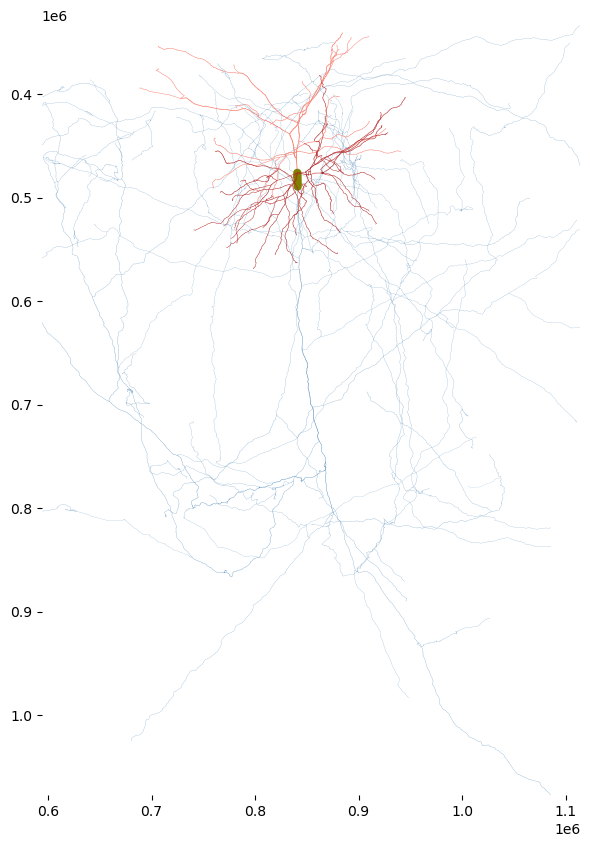

In [31]:
f, ax = plt.subplots(figsize=(7, 10))

skelplot.plot_tools.plot_verts(sk_done.vertices, 
                               sk_done.edges, 
                               sk_done.radius,
                               sk_done.vertex_types, 
                               x="z",
                               y="y")

ax.spines['right'].set_visible(False) 
ax.spines['left'].set_visible(False) 
ax.spines['top'].set_visible(False) 
ax.spines['bottom'].set_visible(False)
plt.gca().invert_yaxis()

### generate meshwork skeleton from precomputed

Reference: https://github.com/AllenInstitute/skeleton_plot/blob/main/skeleton_plot/skel_io.py

In [32]:
from meshparty import skeleton

In [33]:
sk_meshwork = skeleton.Skeleton(sk_done.vertices, 
                               sk_done.edges, 
                               vertex_properties={'radius': sk_done.radius,
                                                  'compartment': sk_done.vertex_types}, 
                               root=len(sk_done.edges), # final edge is root
                               remove_zero_length_edges=False)

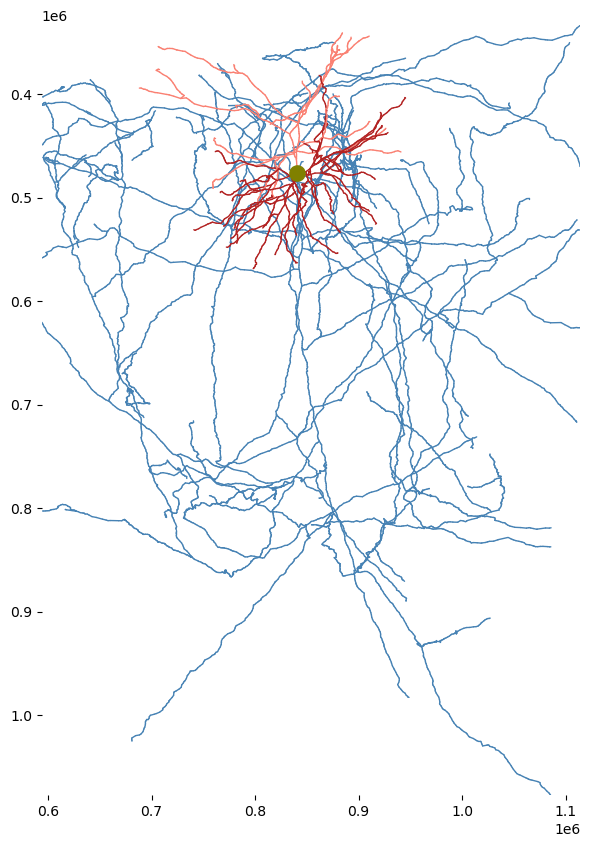

In [34]:
f, ax = plt.subplots(figsize=(7, 10))
skelplot.plot_tools.plot_skel(
    sk_meshwork,
    line_width=1,
    plot_soma=True,
    invert_y=True,
    pull_compartment_colors=True,
    x="z",
    y="y",
)

ax.spines['right'].set_visible(False) 
ax.spines['left'].set_visible(False) 
ax.spines['top'].set_visible(False) 
ax.spines['bottom'].set_visible(False)
# ax.axis('off')

### exploring meshwork functions

In [81]:
dir(sk_meshwork)

['SkeletonIndex',
 '_SkeletonIndex',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_branch_points',
 '_compute_cover_paths',
 '_compute_segments',
 '_cover_paths',
 '_create_branch_and_end_points',
 '_create_default_root',
 '_csgraph_filtered',
 '_edges',
 '_end_points',
 '_kdtree',
 '_meta',
 '_node_mask',
 '_pykdtree',
 '_register_skeleton_index',
 '_reset_derived_properties_filtered',
 '_reset_derived_properties_rooted',
 '_rooted',
 '_segment_map',
 '_segments',
 '_single_path_length',
 '_vertices',
 'apply_mask',
 'branch_points',
 'branch_points_undirected',
 'child_nodes',
 'copy',
 'cover_paths',
 'cover_paths_specific',
 'cover_paths_with_p

In [83]:
sk_meshwork.segments
sk_meshwork.downstream_nodes?

Signature: sk_meshwork.downstream_nodes(vinds, inclusive=True)
Docstring:
Get a list of all nodes downstream of a collection of indices

Parameters
----------
vinds : Collection of ints
    Collection of vertex indices

Returns
-------
List of arrays
    List whose ith element is an array of all vertices downstream of the ith element of vinds.
File:      c:\users\bethanny.danskin\anaconda3\envs\microns_2024\lib\site-packages\meshparty\skeleton.py
Type:      method

In [84]:
sk_meshwork.branch_points
sk_meshwork.n_branch_points

# sk_meshwork.vertices
# sk_meshwork.n_vertices

# sk_meshwork.end_points
# sk_meshwork.n_end_points

137

In [85]:
sk_meshwork.path_length?
sk_meshwork.path_between?
sk_meshwork.path_to_root?

Signature: sk_meshwork.path_to_root(v_ind)
Docstring: Path stops if it leaves masked region
File:      c:\users\bethanny.danskin\anaconda3\envs\microns_2024\lib\site-packages\meshparty\skeleton.py
Type:      method

In [86]:
# Total path length
sk_meshwork.path_length() / 1_000 # Convert to microns from nanometers by dividing by 10^3

27250.124

In [87]:
sk_meshwork.vertex_properties['compartment']

array([2., 2., 2., ..., 2., 2., 1.], dtype=float32)

In [91]:
# directory functions; # note: skeleton.get() accepts a list of ids
skel_list = cv_local.cache.list_skeletons()
skel_list.remove('info') # remove the metadatat file, which is not a valid skeleton
skel_list

['1', '10', '2', '3', '394398', '864691135118968029', '864691135122603047']

In [93]:
axon_inds = sk_meshwork.vertex_properties['compartment']==2
dendrite_inds = (sk_meshwork.vertex_properties['compartment']==3) | (sk_meshwork.vertex_properties['compartment']==4)

In [100]:
sk_meshwork.reset_mask(in_place=True)

sk_meshwork.apply_mask(axon_inds).path_length() / 1_000

22527.364

In [101]:
sk_meshwork.apply_mask(dendrite_inds).path_length() / 1_000

4595.3605

In [106]:
sk_meshwork.n_vertices

sk_axon = sk_meshwork.apply_mask(axon_inds)
sk_axon.n_vertices

11716

## Compartment label conventions 
Standardized swc files (www.neuromorpho.org) - 
- 0 - undefined
- 1 - soma
- 2 - axon
- 3 - (basal) dendrite
- 4 - apical dendrite
- 5+ - custom

Reference for meshwork calculations: https://github.com/AllenInstitute/SWDB_CellTypeFunction/blob/main/code/workshop1/skel_features/extraction.py 

In [108]:
eps = sk_axon.end_points
eps

array([    0,   254,   276,   377,   394,   461,   490,   580,   722,
         736,   931,   965,  1143,  1211,  1228,  1261,  1328,  1387,
        1526,  1646,  1684,  1798,  2056,  2184,  2363,  2562,  3078,
        3163,  3327,  3436,  3522,  3600,  3847,  4483,  4648,  4759,
        4925,  5421,  5568,  5791,  5823,  5867,  5944,  6062,  6069,
        6138,  6353,  6579,  6735,  7036,  7063,  7064,  7271,  7616,
        7627,  7735,  7925,  8158,  8283,  8286,  8318,  8336,  8413,
        8949,  9188,  9347,  9535,  9674,  9697,  9769,  9867,  9900,
       10060, 10114, 10192, 10318, 10338, 10402, 10470, 10801, 10843,
       10882, 10939, 10975, 11025, 11299, 11568, 11599, 11620, 11714],
      dtype=int64)